# Predict CO2 Emissions

<hr>

#### Importing Module

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, learning_curve, cross_val_score

#### Loading the dataset

In [2]:
df = pd.read_csv('data.csv')
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [3]:
df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


<hr>

## Feature Selection

#### Pearson Correlation

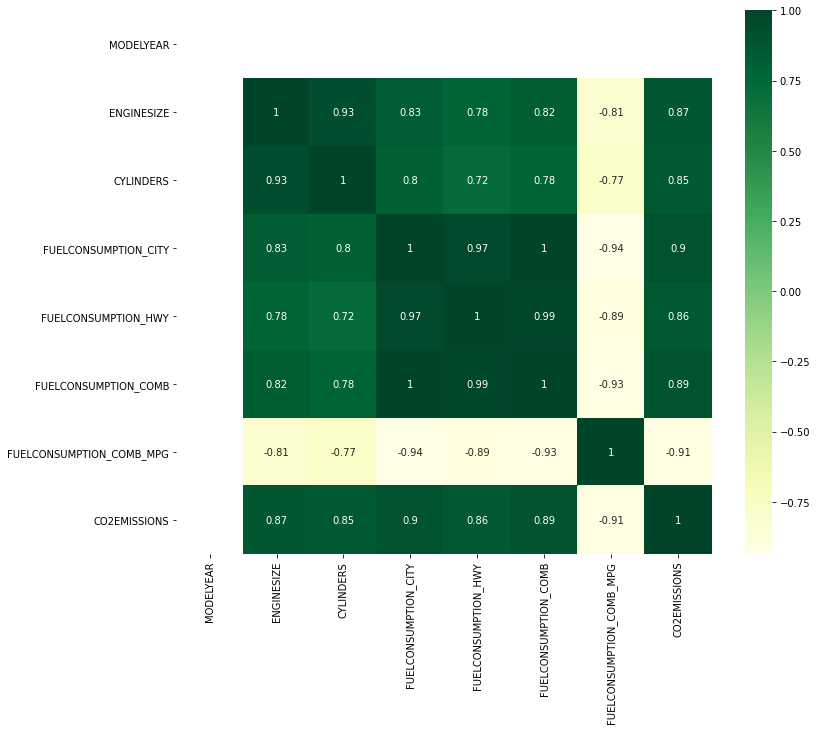

In [4]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.YlGn)
plt.show()

In [5]:
df.corr()['CO2EMISSIONS'].sort_values()

FUELCONSUMPTION_COMB_MPG   -0.906394
CYLINDERS                   0.849685
FUELCONSUMPTION_HWY         0.861748
ENGINESIZE                  0.874154
FUELCONSUMPTION_COMB        0.892129
FUELCONSUMPTION_CITY        0.898039
CO2EMISSIONS                1.000000
MODELYEAR                        NaN
Name: CO2EMISSIONS, dtype: float64

#### Categorical Data

Performing One Hot Encoding

In [6]:
# Select only categorical variables
category_df = df.select_dtypes('object')

# One hot encode the variables
dummy_df = pd.get_dummies(category_df)

# Put the grade back in the dataframe
# dummy_df['Average Grades'] = df['Average Grades']
dummy_df['CO2EMISSIONS'] = df['CO2EMISSIONS']

# Find correlations with grade
# dummy_df.corr()['Average Grades'].sort_values()
dummy_df.corr()['CO2EMISSIONS'].sort_values()

VEHICLECLASS_COMPACT           -0.273466
TRANSMISSION_AV                -0.243493
FUELTYPE_X                     -0.230304
VEHICLECLASS_MID-SIZE          -0.210129
MAKE_MINI                      -0.199720
                                  ...   
TRANSMISSION_A4                 0.241145
MAKE_GMC                        0.249436
VEHICLECLASS_SUV - STANDARD     0.275347
VEHICLECLASS_VAN - PASSENGER    0.354016
CO2EMISSIONS                    1.000000
Name: CO2EMISSIONS, Length: 745, dtype: float64

#### ENGINESIZE

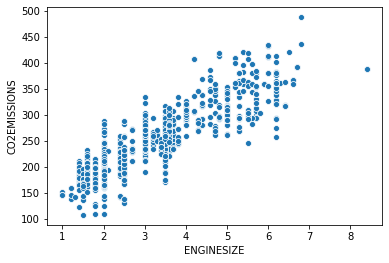

In [7]:
sns.scatterplot(x='ENGINESIZE', y='CO2EMISSIONS', data=df)

#### CYLINDERS

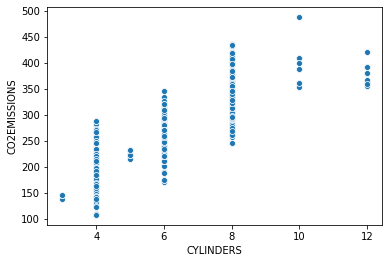

In [8]:
sns.scatterplot(x='CYLINDERS', y='CO2EMISSIONS', data=df)

#### FUELCONSUMPTION_CITY

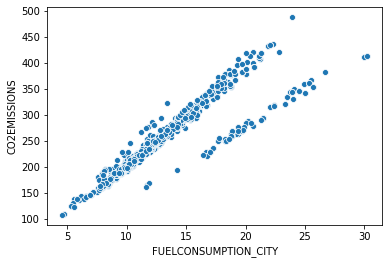

In [9]:
sns.scatterplot(x='FUELCONSUMPTION_CITY', y='CO2EMISSIONS', data=df)

#### FUELCONSUMPTION_HWY

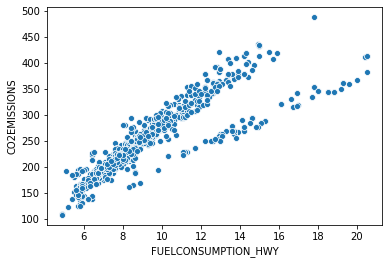

In [10]:
sns.scatterplot(x='FUELCONSUMPTION_HWY', y='CO2EMISSIONS', data=df)

#### FUELCONSUMPTION_COMB

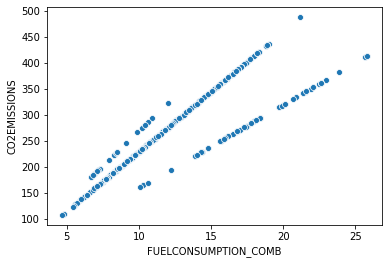

In [11]:
sns.scatterplot(x='FUELCONSUMPTION_COMB', y='CO2EMISSIONS', data=df)

#### Pearson Correlation

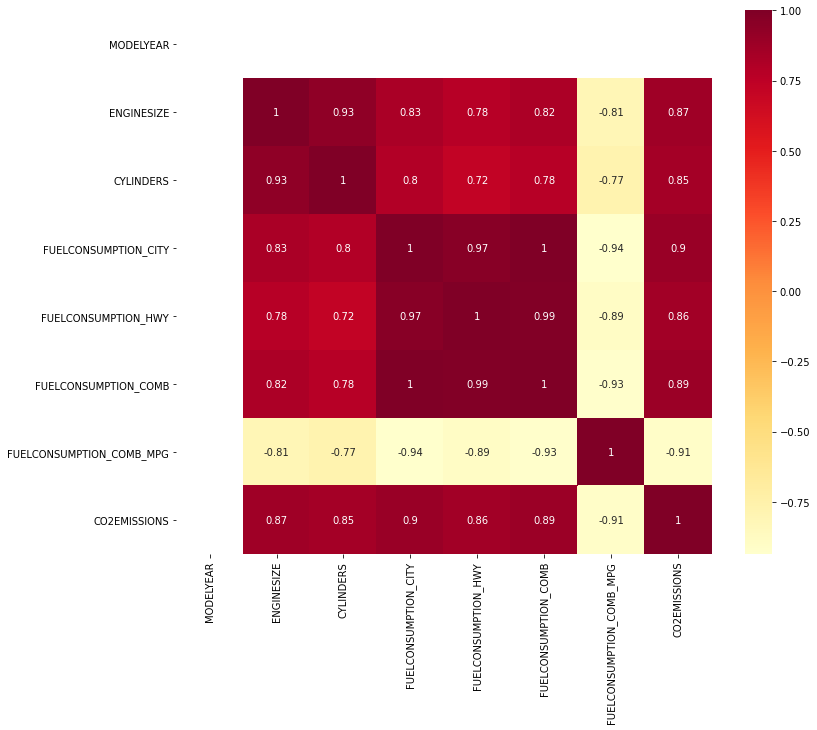

In [12]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.YlOrRd)
plt.show()

Since 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB' are highly correlated so we will use only one of these features

#### Final Features

In [13]:
df = df[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
df.head()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_COMB,CO2EMISSIONS
0,2.0,4,8.5,196
1,2.4,4,9.6,221
2,1.5,4,5.9,136
3,3.5,6,11.1,255
4,3.5,6,10.6,244


<hr>

## Creating the model

In [14]:
kf = KFold(n_splits=10, shuffle=True)

#### Shuffling the dataframe

In [15]:
_df = df.sample(frac=1, random_state=999)

#### Splitting the dataset

In [16]:
features = ['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB']
target = ['CO2EMISSIONS']

train_dataset = _df[:900]
X_train = train_dataset[features]
y_train = train_dataset[target]

test_dataset = _df[901:1067]
X_test = test_dataset[features]
y_test = test_dataset[target]

#### Feature Scaling 

In [17]:
scaler = StandardScaler()

X_train = scaler.fit_transform(np.asanyarray(X_train))
y_train = np.asanyarray(y_train)

X_test = scaler.fit_transform(np.asanyarray(X_test))
y_test = np.asanyarray(y_test)

#### Cross Validation

In [18]:
scoring = 'r2'
score = cross_val_score(linear_model.LinearRegression(), X_train, y_train, cv=kf, scoring=scoring)

score.mean()

0.855371204014669

#### Learning Curve

In [19]:
_sizes = [i for i in range(1, 720, 20)]
train_sizes = np.array([_sizes])  # Relative sizes
scoring = 'neg_mean_squared_error'

lr = linear_model.LinearRegression()

train_sizes_abs, train_scores, cv_scores = learning_curve(lr, X_train, y_train, train_sizes=train_sizes, cv=kf, scoring=scoring)

In [20]:
train_scores_mean = []
for row in train_scores:
    _mean = row.mean()
    train_scores_mean.append(_mean)
    
cv_scores_mean = []
for row in cv_scores:
    _mean = row.mean()
    cv_scores_mean.append(_mean)    
    
train_scores_mean = -np.array(train_scores_mean)
cv_scores_mean = -np.array(cv_scores_mean)
    
print(train_scores_mean)
print()
print(cv_scores_mean)

[ -0.          66.30813644 367.63997131 493.94581339 457.55717718
 455.16789399 471.67699948 460.98039308 421.94697709 458.31776848
 479.91746932 489.25879179 488.20625862 509.71726689 505.35004977
 535.43735226 563.66591856 567.90683202 559.89060159 560.21895836
 567.65894977 556.16478732 548.37451255 546.68546053 548.91981535
 552.14818407 555.26089529 544.93384829 547.12141668 555.9121747
 555.11093868 556.60060667 552.28680201 551.40616179 554.17616074
 557.84169154]

[9326.67555556 1254.817194    605.19385135  581.86356299  589.48007705
  590.8883278   576.03058122  570.58364136  568.76552068  567.91582805
  568.05504112  571.58104964  567.55438754  565.10304416  561.87742895
  562.18699476  560.59076677  559.75235256  562.12365281  562.00998883
  560.91498681  560.49249288  560.96361066  560.48392572  560.45739274
  560.31465004  559.33263621  560.66854352  559.04503817  559.88975384
  560.91252373  561.12747017  560.86439781  562.50718185  560.4694893
  560.50567852]


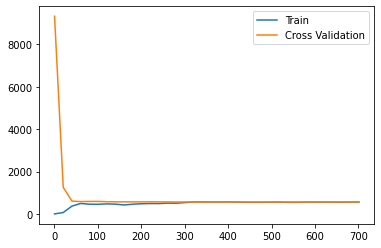

In [21]:
plt.plot(train_sizes_abs, train_scores_mean, label='Train')
plt.plot(train_sizes_abs, cv_scores_mean, label='Cross Validation')

plt.legend()

#### Fitting the model

In [22]:
model = lr.fit(X_train, y_train)

#### Optimal Parameters

In [23]:
coefficient = model.coef_
intercept = model.intercept_

print("Coefficient: ", coefficient)
print("Intercept: ", model.intercept_)

Coefficient:  [[15.54083094 12.89314067 32.94056637]]
Intercept:  [256.44888889]


#### Predictions

In [24]:
y_test_pred = model.predict(X_test)
y_test_pred.astype('int64')

array([[283],
       [381],
       [197],
       [259],
       [340],
       [220],
       [255],
       [250],
       [194],
       [206],
       [315],
       [217],
       [262],
       [208],
       [207],
       [281],
       [239],
       [308],
       [194],
       [208],
       [193],
       [264],
       [357],
       [205],
       [213],
       [189],
       [242],
       [244],
       [267],
       [193],
       [371],
       [193],
       [220],
       [178],
       [204],
       [188],
       [188],
       [253],
       [261],
       [207],
       [277],
       [359],
       [357],
       [297],
       [191],
       [365],
       [260],
       [264],
       [248],
       [349],
       [201],
       [210],
       [198],
       [262],
       [249],
       [255],
       [212],
       [378],
       [303],
       [205],
       [174],
       [263],
       [209],
       [197],
       [203],
       [357],
       [187],
       [365],
       [216],
       [205],
       [251],
      

In [25]:
y_test

array([[281],
       [389],
       [184],
       [278],
       [396],
       [225],
       [253],
       [235],
       [166],
       [205],
       [347],
       [228],
       [267],
       [214],
       [200],
       [310],
       [209],
       [338],
       [177],
       [202],
       [177],
       [276],
       [356],
       [200],
       [216],
       [138],
       [232],
       [237],
       [283],
       [179],
       [350],
       [179],
       [237],
       [136],
       [205],
       [166],
       [161],
       [258],
       [271],
       [207],
       [308],
       [320],
       [359],
       [292],
       [168],
       [380],
       [262],
       [276],
       [237],
       [419],
       [196],
       [221],
       [182],
       [271],
       [239],
       [246],
       [202],
       [393],
       [277],
       [196],
       [110],
       [274],
       [196],
       [191],
       [191],
       [356],
       [131],
       [380],
       [225],
       [212],
       [246],
      

#### Evaluation

In [26]:
rms_error = mean_squared_error(y_test, y_test_pred)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")

Root mean squared error: 532.6249498188291
R2-score: 0.8811482736499913


#### Pipeline

In [27]:
from sklearn.pipeline import Pipeline

In [28]:
scaling = ('scale', StandardScaler())
model = ('model', linear_model.LinearRegression())

# Steps in the pipeline
steps = [scaling, model]

pipe = Pipeline(steps=steps)

# Fiitting the model
model = pipe.fit(X_train, y_train)

# Out-Of-Sample Forecast
y_test_pred = model.predict(X_test)

# Evaluation
rms_error = mean_squared_error(y_test, y_test_pred, squared=False)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")

Root mean squared error: 23.078668718512105
R2-score: 0.8811482736499913


#### Saving the model

In [29]:
from joblib import dump

dump(model, 'model.joblib')

['model.joblib']

#### Visualizing our prediction against actual values

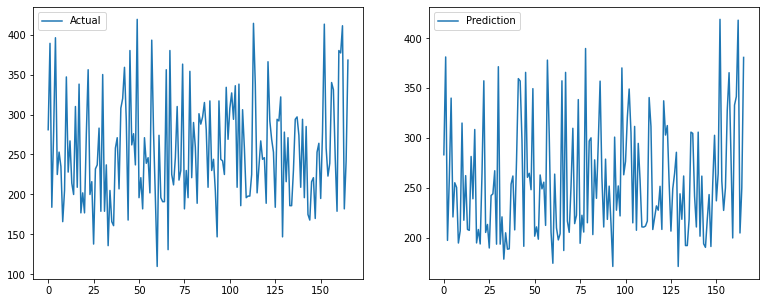

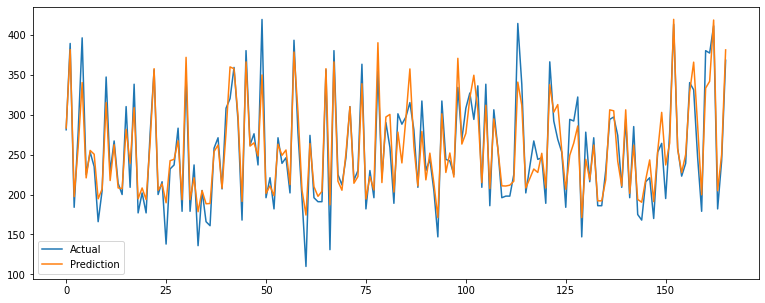

In [30]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax1.plot(np.arange(len(y_test)), y_test, label='Actual')
ax2.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax1.legend()
ax2.legend()

f, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))

ax3.plot(np.arange(len(y_test)), y_test, label='Actual')
ax3.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax3.legend()

<hr>